In [1]:

from __future__ import print_function


from osgeo import ogr

# Open the dataset from the file
dataset = ogr.Open("D:/Courses/Fall 2019/Probabilistic modelling/Project/Last_training.shp")
# Make sure the dataset exists -- it would be None if we couldn't open it
if not dataset:
    print('Error: could not open dataset')

In [2]:
### Let's get the driver from this file
driver = dataset.GetDriver()
print('Dataset driver is: {n}\n'.format(n=driver.name))

### How many layers are contained in this Shapefile?
layer_count = dataset.GetLayerCount()
print('The shapefile has {n} layer(s)\n'.format(n=layer_count))


layer = dataset.GetLayerByIndex(0)
print('The layer is named: {n}\n'.format(n=layer.GetName()))

### What is the layer's geometry? is it a point? a polyline? a polygon?
# First read in the geometry - but this is the enumerated type's value
geometry = layer.GetGeomType()

# So we need to translate it to the name of the enum
geometry_name = ogr.GeometryTypeToName(geometry)
print("The layer's geometry is: {geom}\n".format(geom=geometry_name))

### What is the layer's projection?
# Get the spatial reference
spatial_ref = layer.GetSpatialRef()

# Export this spatial reference to something we can read... like the Proj4
proj4 = spatial_ref.ExportToProj4()
print('Layer projection is: {proj4}\n'.format(proj4=proj4))

### How many features are in the layer?
feature_count = layer.GetFeatureCount()
print('Layer has {n} features\n'.format(n=feature_count))

### How many fields are in the shapefile, and what are their names?
# First we need to capture the layer definition
defn = layer.GetLayerDefn()

# How many fields
field_count = defn.GetFieldCount()
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for i in range(field_count):
    field_defn = defn.GetFieldDefn(i)
    print('\t{name} - {datatype}'.format(name=field_defn.GetName(),
                                         datatype=field_defn.GetTypeName()))

Dataset driver is: ESRI Shapefile

The shapefile has 1 layer(s)

The layer is named: Last_training

The layer's geometry is: Polygon

Layer projection is: +proj=longlat +datum=WGS84 +no_defs 

Layer has 5 features

Layer has 7 fields
Their names are: 
	Classcode - String
	Classname - String
	Classvalue - Integer64
	RED - Integer64
	GREEN - Integer64
	BLUE - Integer64
	Count - Integer64


In [3]:
# Import GDAL
from osgeo import gdal

# First we will open our raster image, to understand how we will want to rasterize our vector
raster_ds = gdal.Open("D:/Courses/Fall 2019/Probabilistic modelling/Project/Clip_composite_1_11_Kaski.tif", gdal.GA_ReadOnly)

# Fetch number of rows and columns
ncol = raster_ds.RasterXSize
nrow = raster_ds.RasterYSize

# Fetch projection and extent
proj = raster_ds.GetProjectionRef()
ext = raster_ds.GetGeoTransform()

raster_ds = None

# Create the raster dataset
memory_driver = gdal.GetDriverByName('GTiff')
out_raster_ds = memory_driver.Create("D:/Courses/Fall 2019/Probabilistic modelling/Project/temp/training_data1.gtif", ncol, nrow, 1, gdal.GDT_Byte)

# Set the ROI image's projection and extent to our input raster's projection and extent
out_raster_ds.SetProjection(proj)
out_raster_ds.SetGeoTransform(ext)

# Fill our output band with the 0 blank, no class label, value
b = out_raster_ds.GetRasterBand(1)
b.Fill(0)

# Rasterize the shapefile layer to our new dataset
status = gdal.RasterizeLayer(out_raster_ds,  # output to our new dataset
                             [1],  # output to our new dataset's first band
                             layer,  
                             None, None,  
                             ['ALL_TOUCHED=TRUE',  # rasterize all pixels touched by polygons
                              'ATTRIBUTE=Classvalue']  # put raster values according to the 'id' field values
                             )

# Close dataset
out_raster_ds = None

if status != 0:
    print("I don't think it worked...")
else:
    print("Success")

Success


In [4]:
# Import NumPy for some statistics
import numpy as np

roi_ds = gdal.Open("D:/Courses/Fall 2019/Probabilistic modelling/Project/temp/training_data1.gtif", gdal.GA_ReadOnly)

roi = roi_ds.GetRasterBand(1).ReadAsArray()

# How many pixels are in each class?
classes = np.unique(roi)
# Iterate over all class labels in the ROI image, printing out some information
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(roi == c).sum()))

Class 0 contains 4330821 pixels
Class 1 contains 2779 pixels
Class 2 contains 3154 pixels
Class 3 contains 718 pixels
Class 4 contains 967 pixels
Class 5 contains 811 pixels


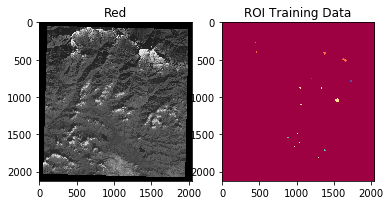

In [5]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open("D:/Courses/Fall 2019/Probabilistic modelling/Project/Clip_composite_1_11_Kaski.tif", gdal.GA_ReadOnly)
roi_ds = gdal.Open("D:/Courses/Fall 2019/Probabilistic modelling/Project/temp/training_data1.gtif", gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('Red')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

In [135]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

# Mask out clouds, cloud shadows, and snow using Fmask
#clear = X[:, 7] <= 1

#X = X[clear, :7]  # we can ditch the Fmask band now
#y = y[clear]

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 8429 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (8429, 11)
Our y array is sized: (8429,)
After masking, our X matrix is sized: (8429, 11)
After masking, our y array is sized: (8429,)


In [137]:
import pandas as pd

X_train=X.copy()
y_train=((pd.get_dummies(y)).copy()).values



In [139]:
# attribute normalization
x_train = X_train.astype( np.float32)
#x_test = x_test.astype( np.float32)
y_train = y_train.astype( np.int32)
#y_test = y_test.astype( np.int32)

x_train=np.zeros(shape=X_train.shape)

def normalize (x):
    z=x
    if (np.min(x)<np.max(x)):
        z=(x-np.min(x))/(np.max(x)-np.min(x))
    return (z)    

    
for i in range(X_train.shape[1]):
    x_train[:,i]=normalize(X_train[:,i])







In [140]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:

class Multiclass_softmax_classifier:
    def __init__(self, D, n, zero_init = False, reg = 1.0, lr = 0.1):
        '''
        :param D: length of feature vector
        :param zero_init: whether use all zero initialization
        :param reg: regularization strength ( precision of prior))
        '''
        self.D = D # no of columns of feature
        self.n=n # no of classes
        self.zero_init = zero_init
        self.reg = reg
        self.lr = lr

        if self.zero_init:
            self.initializer = tf.initializers.zeros( )
        else:
            self.initializer =   tf.initializers.glorot_normal() #tf.initialize_all_variables() 

        self._build_graph()

    def _build_graph(self):
        #model parameters( weights)
        self.w = tf.Variable( self.initializer( shape = [ self.D, self.n] ))
        self.b=tf.Variable(self.initializer(shape=[1, self.n]))
        
        
              

        #Design Matrix and target label
        self.X = tf.placeholder( tf.float32, shape = [None, self.D,])
        self.t = tf.placeholder( tf.float32, shape = [None,self.n])

        # First  hidden layer
        self.y = tf.nn.softmax(tf.matmul(self.X, self.w)+self.b)

  
        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.t * tf.log(self.y),
                                              reduction_indices=[1]))
        self.prior_loss = tf.reduce_mean(tf.reduce_sum( self.w * self.w * self.reg))
        self.map_loss = self.cross_entropy #+self.prior_loss
        

        #minimizer
        self.min_opt = tf.train.AdamOptimizer(self.lr)

        #minimizing step
        self.min_step = self.min_opt.minimize( self.map_loss)                                    
       
        #GPU settings
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config)
        self.run_options = tf.RunOptions(report_tensor_allocations_upon_oom=True)
        self.sess.run(tf.global_variables_initializer())

    def fit(self,X, t, num_iter =100, verbose = True):
        '''
        :param X: Design Matrix, N by D
        :param t: target, N by None
        :return: self
        '''
       
        self.train_hist = []
        for i in range( num_iter):
            train_feed_dict = { self.X:X, self.t:t}
            _,cross_loss, map_loss,w = self.sess.run( [ self.min_step,  self.cross_entropy,self.map_loss, self.w], feed_dict=train_feed_dict)
            if verbose:
                print("iter %3d:  map loss = %f , " % ( i + 1, map_loss), "cross loss=%f," %(cross_loss)," w = ", w)
               
            self.train_hist.append( map_loss)
        return self

    def predict(self,X):
        test_feed_dict = { self.X:X}

        y_pred = self.sess.run( self.y, feed_dict=test_feed_dict)
        y_pred=np.argmax(y_pred, axis=1)+1

        return y_pred

In [149]:
NR_clf = Multiclass_softmax_classifier( x_train.shape[1],5, zero_init = False, reg = 1.0)
_ = NR_clf.fit( x_train, y_train,verbose = True)

iter   1:  map loss = 1.951306 ,  cross loss=1.951306,  w =  [[-0.05387984 -0.69668925 -0.04394812 -0.55709904  0.48631462]
 [-0.02581331 -0.5784482   0.01849196 -0.3911522  -0.64535296]
 [-0.53848433 -0.28655648 -0.54225415 -0.44424573 -0.7222663 ]
 [ 0.08546682  0.0960264  -0.08513171 -0.3111121  -0.68557817]
 [-0.16590922  0.4112367   0.514001   -0.5417601  -0.19301862]
 [-0.26481143 -0.6963436  -0.32663792 -0.14149778 -0.22977856]
 [ 0.35158923 -0.35584494  0.54885656 -0.05444135 -0.02535695]
 [ 0.33213803 -0.10482887  0.02421364  0.22653651 -0.0919008 ]
 [-0.20434456  0.41199818 -0.26207334 -0.11680763  0.2370415 ]
 [-0.3987377   0.15191257 -0.3261149  -0.23185664 -0.514655  ]
 [-0.2636307   0.35569674  0.15306018  0.35833305 -0.65362704]]
iter   2:  map loss = 1.543284 ,  cross loss=1.543284,  w =  [[ 0.04494579 -0.796729   -0.14266211 -0.655099    0.3879143 ]
 [ 0.07301349 -0.67847824 -0.08022925 -0.489159   -0.7437027 ]
 [-0.4396674  -0.3865955  -0.6409915  -0.54227257 -0.82050

iter  51:  map loss = 0.359534 ,  cross loss=0.359534,  w =  [[ 1.090759   -3.5443735  -0.1622862  -0.797949   -0.9701346 ]
 [ 1.1203622  -3.362301   -0.19996482 -0.7221371  -1.9316535 ]
 [ 0.6008241  -3.0757902  -0.8829489  -0.8786716  -1.728478  ]
 [ 1.2220551  -2.658903   -0.55386525 -1.0130379  -1.1125568 ]
 [ 0.8590239   1.3374144  -0.730846   -2.414769    0.13782325]
 [-2.552753   -1.6993197  -0.22746551 -2.8214822   3.529674  ]
 [-1.2041868  -3.0114017   3.0222552  -2.6097739   3.754194  ]
 [ 1.4713991  -2.8886976  -0.36250567 -0.30435365 -0.8915002 ]
 [ 0.940567   -1.8488194  -2.684438   -1.3805935   2.467237  ]
 [-2.8764157   0.12237999  2.252666    0.44600946 -1.0344684 ]
 [-2.7397673   0.60320944  2.040487    0.86722755 -0.2627497 ]]
iter  52:  map loss = 0.354797 ,  cross loss=0.354797,  w =  [[ 1.0932134  -3.5877311  -0.1395549  -0.7787383  -0.9808012 ]
 [ 1.1228023  -3.403488   -0.17947517 -0.70480084 -1.9392154 ]
 [ 0.6031977  -3.115715   -0.8652435  -0.8640195  -1.73119

In [150]:
train_predict=NR_clf.predict( x_train)

# Identifying the distribution on test set whether its working or not

print('Percentage of snow is {o}%'.format(o=(np.sum(train_predict==1)/8429)*100))
print('Percentage of Forest land is {I}%'.format(I=(np.sum(train_predict==2)/8429)*100))
print('Percentage of Developed is {J}%'.format(J=(np.sum(train_predict==3)/8429)*100))
print('Percentage of Barren is {K}%'.format(K=(np.sum(train_predict==5)/8429)*100))
print('Percentage of Water is {L}%'.format(L=(np.sum(train_predict==4)/8429)*100))




# checking the accuracy on training dataset


train_predict=NR_clf.predict( x_train)

accuracy=(y==train_predict).mean()

print (accuracy)


Percentage of snow is 32.96951002491399%
Percentage of Forest land is 37.73875904615019%
Percentage of Developed is 8.506347134891447%
Percentage of Barren is 9.348677185905801%
Percentage of Water is 11.43670660813857%
0.9967967730454383


# Classifying the complete image



In [154]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification

new_shape = (img.shape[0] * img.shape[1], img.shape[2])

img_as_array = img[:, :, :].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))





Reshaped from (2125, 2042, 11) to (4339250, 11)


In [155]:
# attribute normalization
feature_trial = img_as_array.astype( np.float32)

# creating emppty array for normalization

full_image=np.zeros(shape=img_as_array.shape).astype(np.float32)

    
for i in range(img_as_array.shape[1]):
   full_image[:,i]=normalize(feature_trial[:,i])





In [156]:


class_prediction=NR_clf.predict(full_image )

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)


In [157]:
# Printing the percentage of land occupied by the classes

print('Percentage of snow is {o}%'.format(o=(np.sum(class_prediction==1)/(img.shape[0] * img.shape[1])*100)))
print('Percentage of Forest land is {I}%'.format(I=(np.sum(class_prediction==2)/(img.shape[0] * img.shape[1])*100)))
print('Percentage of Developed is {J}%'.format(J=(np.sum(class_prediction==3)/(img.shape[0] * img.shape[1])*100)))
print('Percentage of Barren is {K}%'.format(K=(np.sum(class_prediction==5)/(img.shape[0] * img.shape[1])*100)))
print('Percentage of Water is {L}%'.format(L=(np.sum(class_prediction==4)/(img.shape[0] * img.shape[1])*100)))

Percentage of snow is 4.19853661347007%
Percentage of Forest land is 14.451160914904648%
Percentage of Developed is 8.091651783142249%
Percentage of Barren is 34.64766952814426%
Percentage of Water is 38.61098116033877%


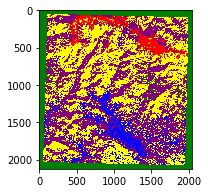

In [158]:
# plotting the classified image

import matplotlib

plt.subplot(122)

labels=np.unique(y)
colors=['red', 'green', 'blue', 'purple','yellow']


plt.imshow(class_prediction, cmap=matplotlib.colors.ListedColormap(colors))

plt.show()
